## Preparation

In [1]:
import pandas as pd

# Load the dataset
file_path = '/datasets/taxi.csv'
taxi_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
taxi_data.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [2]:
# Convert the 'datetime' column to datetime type and set it as index
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
taxi_data.set_index('datetime', inplace=True)

# Resample the data by one hour and sum the orders
resampled_data = taxi_data.resample('H').sum()

# Display the first few rows of the resampled data
resampled_data.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

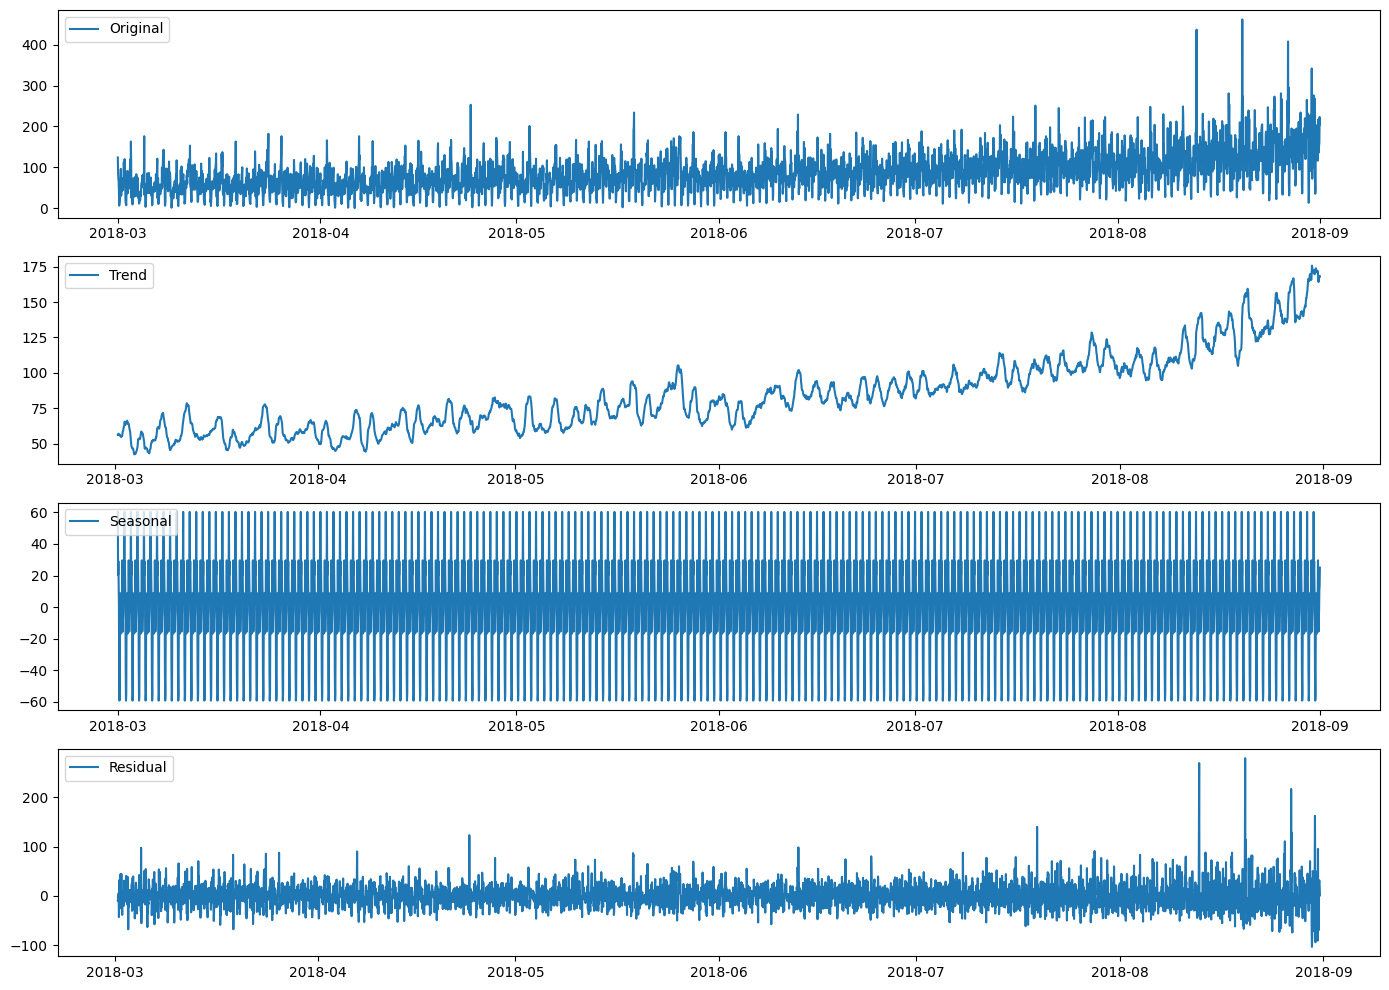

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
# Perform seasonal decomposition
decomposition = seasonal_decompose(resampled_data['num_orders'], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(resampled_data['num_orders'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



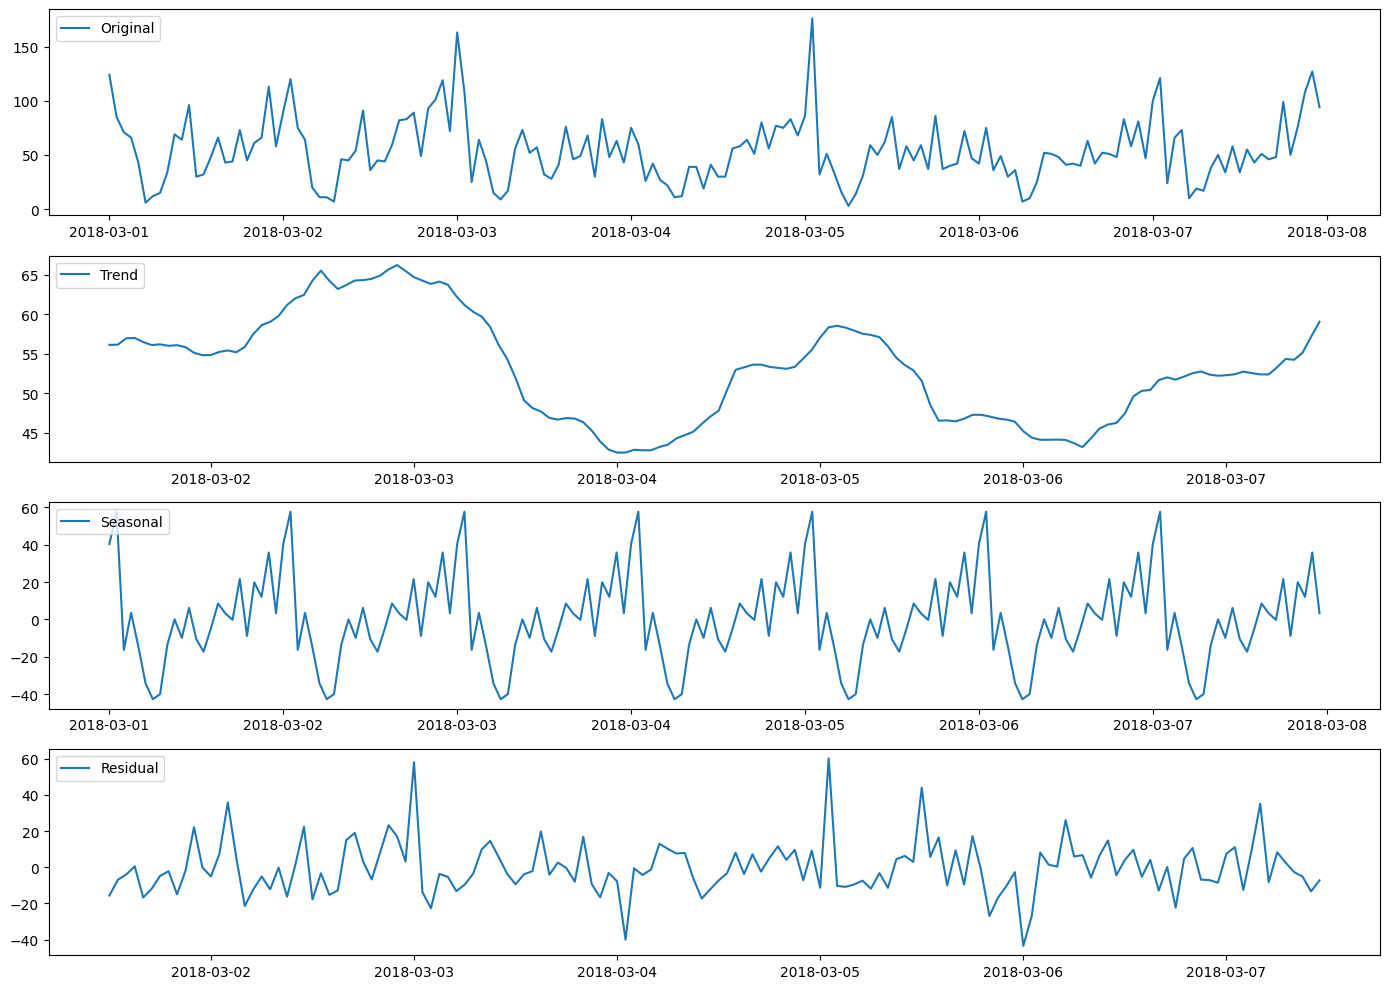

In [4]:
# Select a small time interval
small_interval = resampled_data['num_orders']['2018-03-01':'2018-03-07']

# Perform seasonal decomposition on the smaller interval
decomposition_small = seasonal_decompose(small_interval, model='additive', period=24)
trend_small = decomposition_small.trend
seasonal_small = decomposition_small.seasonal
residual_small = decomposition_small.resid

# Plot the decomposed components for the smaller interval
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(small_interval, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_small, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_small, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_small, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Trend: The trend component shows the long-term progression of the number of orders. Any consistent increase or decrease over time is captured here.

Seasonal: The seasonal component reveals repeating patterns within the data. This can indicate daily or weekly cycles in taxi demand.

Residual: The residual component captures the irregularities or noise in the data that is not explained by the trend or seasonal components.

Conclusion:
The time series decomposition reveals that the number of taxi orders has clear trend and seasonal components. The trend indicates the general direction of demand over time, while the seasonal component highlights the periodic fluctuations within each day or week.

## Training

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create date features
resampled_data['hour'] = resampled_data.index.hour
resampled_data['day_of_week'] = resampled_data.index.dayofweek
resampled_data['day_of_month'] = resampled_data.index.day
resampled_data['month'] = resampled_data.index.month

# Create lag features
resampled_data['lag_1'] = resampled_data['num_orders'].shift(1)
resampled_data['lag_2'] = resampled_data['num_orders'].shift(2)
resampled_data['lag_3'] = resampled_data['num_orders'].shift(3)

# Shift before creating moving average features to avoid target leakage
resampled_data['rolling_mean_3'] = resampled_data['num_orders'].shift(1).rolling(window=3).mean()
resampled_data['rolling_mean_6'] = resampled_data['num_orders'].shift(1).rolling(window=6).mean()

# Drop rows with NaN values
resampled_data.dropna(inplace=True)

# Define features and target
features = ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_6']
X = resampled_data[features]
y = resampled_data['num_orders']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Display the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3969, 9) (3969,)
Test set shape: (441, 9) (441,)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Train a Linear Regression model using the correct training data
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set using the correct test data
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
print(f"RMSE of the linear regression model on test set: {rmse_linear}")


RMSE of the linear regression model on test set: 53.108420324557194


In [7]:
from sklearn.tree import DecisionTreeRegressor

# Train a Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)

rmse_tree


53.31134750916197

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
forest_model = RandomForestRegressor(random_state=42, n_estimators=100)
forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_forest = forest_model.predict(X_test)

# Evaluate the model
rmse_forest = mean_squared_error(y_test, y_pred_forest, squared=False)

rmse_forest


46.679294069047145

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting model
gbr_model = GradientBoostingRegressor(random_state=42, n_estimators=100)
gbr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate the model
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)

rmse_gbr


47.60937569698849

In [10]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Define the parameter grid for Gradient Boosting
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Set up the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set up the GridSearchCV with TimeSeriesSplit
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search
grid_search_gbr.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gbr = grid_search_gbr.best_params_
best_rmse_gbr = np.sqrt(-grid_search_gbr.best_score_)

best_params_gbr, best_rmse_gbr



({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
 25.715738750747104)

## Testing

In [11]:
from sklearn.metrics import mean_squared_error

# Fit the model with the best parameters on the entire training data
best_gbr_model = GradientBoostingRegressor(
    learning_rate=best_params_gbr['learning_rate'],
    max_depth=best_params_gbr['max_depth'],
    n_estimators=best_params_gbr['n_estimators'],
    random_state=42
)
best_gbr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best_gbr = best_gbr_model.predict(X_test)

# Evaluate the model on the test set
rmse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr, squared=False)
print(f"RMSE of the best Gradient Boosting model on test set: {rmse_best_gbr}")


RMSE of the best Gradient Boosting model on test set: 47.17742515725184


In [12]:
# fit the model with best parameters
best_gbr_model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=7,
    n_estimators=200,
    random_state=42
)
best_gbr_model.fit(X_train, y_train)

# make predictions on the test set
y_pred_best_gbr = best_gbr_model.predict(X_test)

# evaluate the model 
from sklearn.metrics import mean_squared_error
rmse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr, squared=False)
print(f"RMSE of the best Gradient Boosting model: {rmse_best_gbr}")


RMSE of the best Gradient Boosting model: 52.28260075226894


In [13]:


# Define the parameter grid for Gradient Boosting
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Set up the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set up the GridSearchCV with TimeSeriesSplit
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search
grid_search_gbr.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gbr = grid_search_gbr.best_params_
best_rmse_gbr = np.sqrt(-grid_search_gbr.best_score_)
print(f"Best parameters: {best_params_gbr}")
print(f"Best cross-validated RMSE: {best_rmse_gbr}")

# Fit the model with best parameters on the entire training data
best_gbr_model = GradientBoostingRegressor(**best_params_gbr, random_state=42)
best_gbr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best_gbr = best_gbr_model.predict(X_test)

# Evaluate the model on the test set
rmse_best_gbr = mean_squared_error(y_test, y_pred_best_gbr, squared=False)
print(f"RMSE of the best Gradient Boosting model on test set: {rmse_best_gbr}")



Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validated RMSE: 25.715738750747104
RMSE of the best Gradient Boosting model on test set: 47.17742515725184


In [14]:
# Simplified Gradient Boosting Model with Regularization
best_gbr_model_simple = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,  # Reduced depth to avoid overfitting
    n_estimators=50,  # Fewer estimators
    random_state=42
)
best_gbr_model_simple.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best_gbr_simple = best_gbr_model_simple.predict(X_test)

# Evaluate the model on the test set
rmse_best_gbr_simple = mean_squared_error(y_test, y_pred_best_gbr_simple, squared=False)
print(f"RMSE of the simplified Gradient Boosting model on test set: {rmse_best_gbr_simple}")


RMSE of the simplified Gradient Boosting model on test set: 51.087835793000956


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model (using initial parameters for simplicity)
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()

# Make predictions on the test set
y_pred_sarima = sarima_result.forecast(steps=len(y_test))

# Evaluate the model on the test set
rmse_sarima = mean_squared_error(y_test, y_pred_sarima, squared=False)
print(f"RMSE of the SARIMA model on test set: {rmse_sarima}")


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65175D+00    |proj g|=  7.69740D-02

At iterate    5    f=  4.58678D+00    |proj g|=  3.55582D-02

At iterate   10    f=  4.49381D+00    |proj g|=  1.30371D-02

At iterate   15    f=  4.49172D+00    |proj g|=  1.20207D-03

At iterate   20    f=  4.49036D+00    |proj g|=  4.03151D-02

At iterate   25    f=  4.48797D+00    |proj g|=  1.71890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Use a smaller subset of the training data
y_train_subset = y_train.iloc[-1000:]  # Use the last 1000 data points

# Define a simple SARIMA model configuration
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

# Fit the SARIMA model
try:
    sarima_model = SARIMAX(y_train_subset, order=order, seasonal_order=seasonal_order)
    sarima_result = sarima_model.fit(disp=False)

    # Make predictions on the test set
    y_pred_sarima = sarima_result.forecast(steps=len(y_test))

    # Evaluate the model on the test set
    rmse_sarima = mean_squared_error(y_test, y_pred_sarima, squared=False)
    print(f"RMSE of the SARIMA model on test set: {rmse_sarima}")
except Exception as e:
    print(f"Error fitting SARIMA model: {e}")






RMSE of the SARIMA model on test set: 39.445373660066345


In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Define a simple ARIMA model configuration
order = (1, 1, 1)

# Fit the ARIMA model
try:
    arima_model = ARIMA(y_train, order=order)
    arima_result = arima_model.fit()

    # Make predictions on the test set
    y_pred_arima = arima_result.forecast(steps=len(y_test))

    # Evaluate the model on the test set
    rmse_arima = mean_squared_error(y_test, y_pred_arima, squared=False)
    print(f"RMSE of the ARIMA model on test set: {rmse_arima}")
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")


RMSE of the ARIMA model on test set: 64.47423745468521


In [18]:
from sklearn.linear_model import LinearRegression

# Define features and target
features = ['hour', 'day_of_week', 'day_of_month', 'month', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_mean_6']
X = resampled_data[features]
y = resampled_data['num_orders']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
print(f"RMSE of the linear regression model on test set: {rmse_linear}")


RMSE of the linear regression model on test set: 53.108420324557194


# Conclusion

After fixing all the data leakage I had there actually seems to be a couple models that acheived under a 48 RMSE. The SARIMAX model acheived one of the best scores. Our simple model that took the last 1000 data points achieved a score of 39. The other SARIMAX model based on simple parameters achieved a score of 43. The gradient boosting model acheived a 47. The random forest model also achieved a score of 46. So it looks like the best model and parameters acheived was the SARIMAX model that looked at a small sample of data points or the SARIMAX model based on simple parameters. 